## 处理原始情绪评分并计算被试间一致性
* 删掉对应run开头和结尾的TR 与fmri时间序列对齐 原始长度为3599 删掉后为3543
* 保存为删掉重叠时间点后的评分和组平均评分
* 计算评分的被试间一致性

In [33]:
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from itertools import combinations
from scipy.stats import zscore

In [ ]:
file_path = '/share/user_data/public/public/experiment/emofMRI/ForrestGump/emotion_rating_process/raw_ratings.mat'  
data_dict = {}

with h5py.File(file_path, 'r') as mat_data:
    for name in mat_data.keys():
        data = mat_data[name][:]

        # Ensure data is flattened if it is multidimensional, or convert each entry into a list
        data_dict[name] = data if data.ndim == 1 else data.flatten()

df = pd.DataFrame(data_dict)

In [5]:
emotion_labels = ['happiness', 'surprise', 'fear', 'sadness', 'anger', 'disgust']
data_frames = []

with h5py.File(file_path, 'r') as mat_data:
    for sub_name in mat_data.keys():
        data = mat_data[sub_name][:]
        sub_df = pd.DataFrame(data.T, columns=emotion_labels)
        sub_df['subject'] = sub_name
        sub_df['time_points'] = range(1, len(sub_df) + 1)  # 添加时间点列
        data_frames.append(sub_df)

final_df = pd.concat(data_frames, ignore_index=True)
final_df

,happiness,surprise,fear,sadness,anger,disgust,subject,time_points
0,0.0,0.0,0.0,0.0,0.0,0.0,sub1,1
1,0.0,0.0,0.0,0.0,0.0,0.0,sub1,2
2,0.0,0.0,0.0,0.0,0.0,0.0,sub1,3
3,0.0,0.0,0.0,0.0,0.0,0.0,sub1,4
4,0.0,0.0,0.0,0.0,0.0,0.0,sub1,5
...,...,...,...,...,...,...,...,...
43183,0.0,0.0,0.0,0.0,0.0,0.0,sub9,3595
43184,0.0,0.0,0.0,0.0,0.0,0.0,sub9,3596
43185,0.0,0.0,0.0,0.0,0.0,0.0,sub9,3597
43186,0.0,0.0,0.0,0.0,0.0,0.0,sub9,3598


In [6]:
def create_mask(segment_lengths):
    """创建mask，标记要保留的时间点"""
    mask = np.ones(sum(segment_lengths), dtype=bool)
    
    # 第一个片段: 只删除结尾5个TR
    current_pos = 0
    mask[current_pos + segment_lengths[0]-5:current_pos + segment_lengths[0]] = False
    current_pos += segment_lengths[0]
    
    # 中间片段: 删除开头3个TR和结尾5个TR
    for length in segment_lengths[1:-1]:
        mask[current_pos:current_pos + 3] = False  # 删除开头
        mask[current_pos + length-5:current_pos + length] = False  # 删除结尾
        current_pos += length
    
    # 最后一个片段: 只删除开头3个TR
    mask[current_pos:current_pos + 3] = False
    
    return mask

def apply_mask_to_data(df, mask):
    """对数据框应用mask"""
    # 提取所有被试ID
    subjects = df['subject'].unique()
    
    # 为每个被试应用mask
    masked_dfs = []
    for subject in subjects:
        subject_data = df[df['subject'] == subject].copy()
        masked_data = subject_data[mask]
        masked_dfs.append(masked_data)
    
    # 合并所有被试的数据
    result_df = pd.concat(masked_dfs, axis=0)
    return result_df

# 片段长度
segment_lengths = [451, 441, 438, 488, 462, 439, 542, 338]

# 创建mask
mask = create_mask(segment_lengths)


masked_df = apply_mask_to_data(final_df, mask)

# 验证
print(f"原始长度: {len(mask)}")
print(f"保留的时间点数: {mask.sum()}")
print(f"删除的时间点数: {len(mask) - mask.sum()}")

原始长度: 3599
保留的时间点数: 3543
删除的时间点数: 56


* 删掉overlap保存为ratings_delete.csv

In [10]:
time_points = list(range(1, 3544)) * 12
masked_df['time_points'] = time_points
masked_df.to_csv('ratings_delete.csv')

* 删掉overlap组平均保存为ratings_mean_delete.csv

In [35]:
group_mean_ratings = masked_df.drop('subject', axis=1).groupby('time_points').mean()
group_mean_ratings.to_csv('ratings_mean_delete.csv')

* 原始评分矩阵稀疏

In [ ]:
emotions = emotion_labels
subjects = sorted(final_df['subject'].unique())


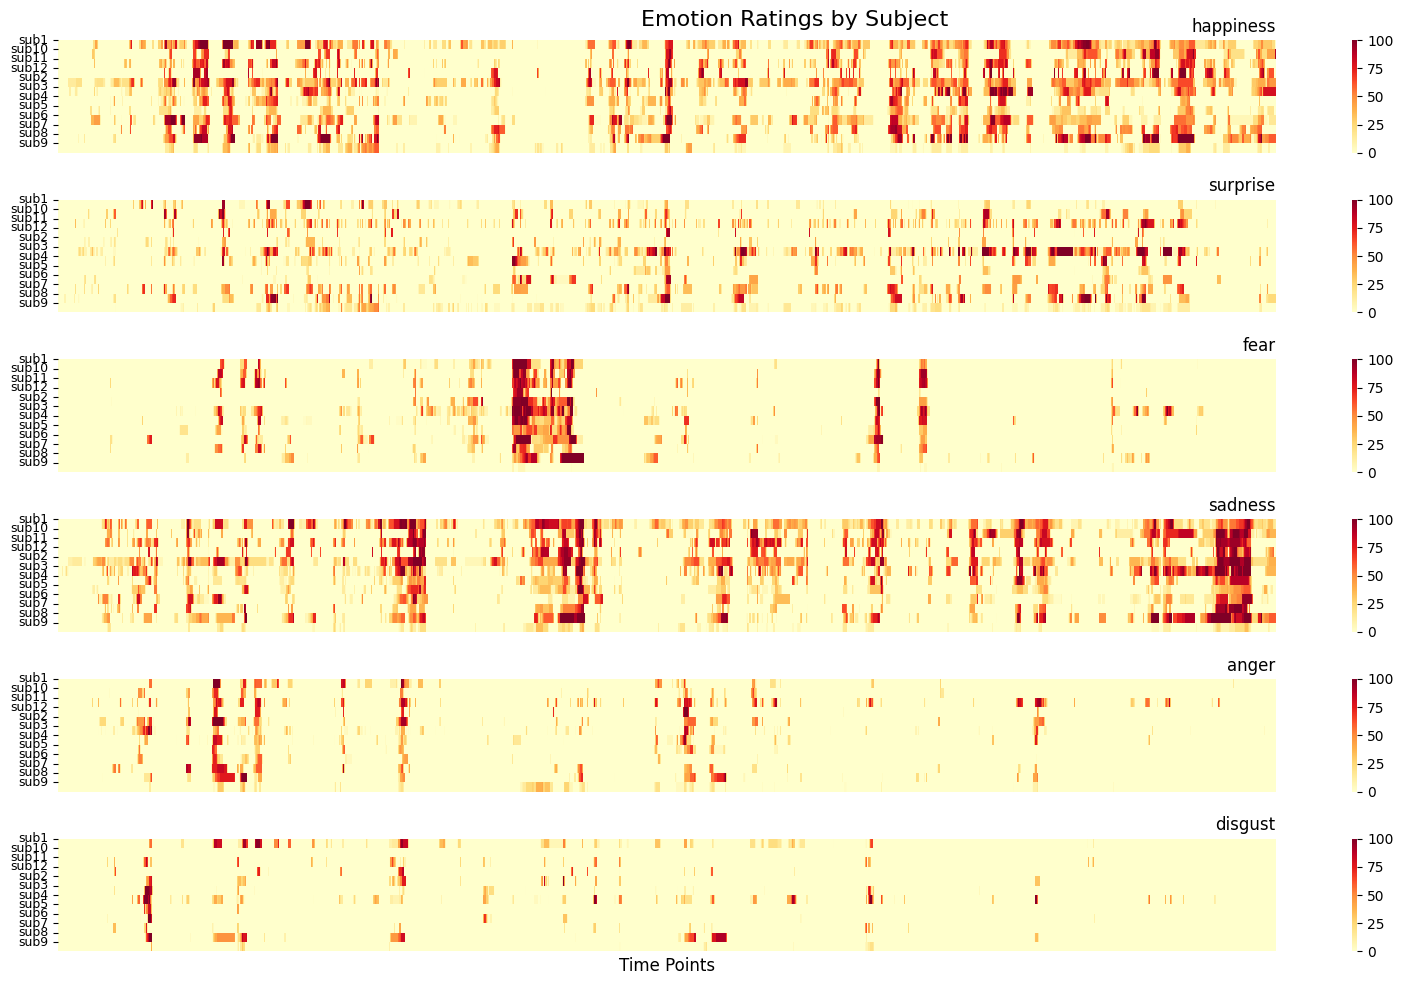

In [27]:
fig, axes = plt.subplots(len(emotions), 1, figsize=(16, 10), sharex=True)
global_max = final_df[emotions].max().max()

for i, emotion in enumerate(emotions):
   matrix = []
   for subject in subjects:
       data = final_df[final_df['subject'] == subject][emotion].values
       matrix.append(data)
   matrix = np.array(matrix)
   
   sns.heatmap(matrix, cmap='YlOrRd', vmin=0, vmax=global_max, 
                ax=axes[i], xticklabels=False)
   axes[i].set_title(emotion, loc='right', fontsize=12)
   axes[i].set_yticks(range(len(subjects)))
   axes[i].set_yticklabels(subjects, fontsize=9, rotation=0)

axes[-1].set_xlabel('Time Points', fontsize=12)
plt.suptitle('Emotion Ratings by Subject', fontsize=16, y=0.98)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

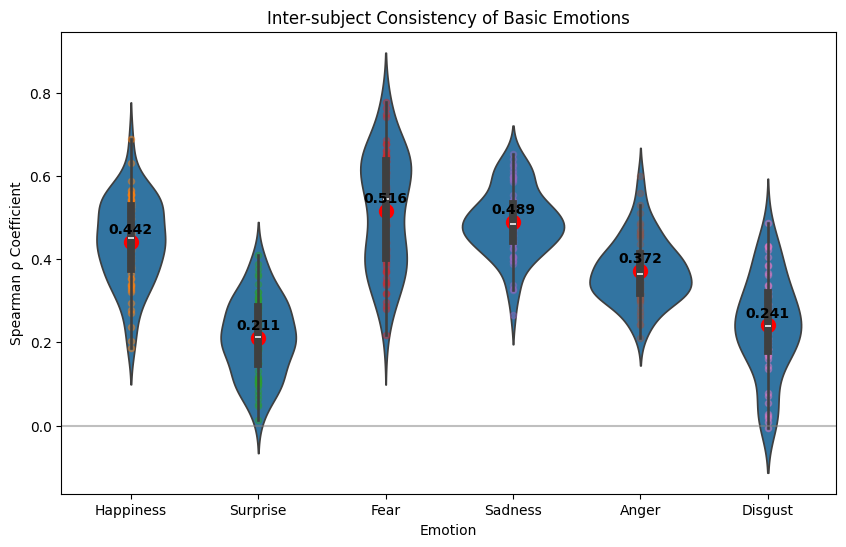

In [31]:
emotion_correlations = {}
for emotion in emotions:
   correlations = []
   for sub1, sub2 in combinations(subjects, 2):
       data1 = final_df[final_df['subject'] == sub1][emotion].values
       data2 = final_df[final_df['subject'] == sub2][emotion].values
       corr, _ = spearmanr(data1, data2)
       correlations.append(corr)
   emotion_correlations[emotion] = correlations

# plot
plot_data = []
for emotion, corrs in emotion_correlations.items():
   for corr in corrs:
       if not np.isnan(corr):
           plot_data.append({'Emotion': emotion.capitalize(), 'Correlation': corr})

plot_df = pd.DataFrame(plot_data)

plt.figure(figsize=(10, 6))
sns.violinplot(data=plot_df, x='Emotion', y='Correlation')

# scatter
for i, emotion in enumerate(emotions):
   corrs = emotion_correlations[emotion]
   valid_corrs = [c for c in corrs if not np.isnan(c)]
   x_pos = [i] * len(valid_corrs)
   plt.scatter(x_pos, valid_corrs, alpha=0.4, s=20)

# mean
means = [np.nanmean(emotion_correlations[emotion]) for emotion in emotions]
for i, mean_val in enumerate(means):
   plt.scatter(i, mean_val, color='red', s=100)
   plt.text(i, mean_val + 0.02, f'{mean_val:.3f}', ha='center', fontweight='bold')

plt.title('Inter-subject Consistency of Basic Emotions')
plt.ylabel('Spearman ρ Coefficient')
plt.axhline(y=0, color='gray', alpha=0.5)
plt.show()